# Análisis de RAIDD Logs de Abril 2023 a Noviembre 2024

## Librerías y CSV
* Carga de librerias
* Carga de CSV
* Exploración inicial de datos

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import unicodedata

In [2]:
from sentence_transformers import SentenceTransformer
import umap
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

C:\Users\simon\Documents\Tesina\testLlama\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
df = pd.read_csv('raidd_logs.csv')

In [4]:
df

,Client Name,Project Name,TECH-Mgmt,Tech Score,RAIDD,Public,Date
0,Embonor,Ecommerce B2C,Tomás Alegre,Neutral,RISKS: \n1. Al no tener validaciones en las va...,Yes,18-04-2023
1,Embonor,Ecommerce B2B,Andrés Mármol,Neutral,RISKS: \n1. Varios puntos de la infraestructur...,Yes,18-04-2023
2,Embonor,PDV,Jose Piamba,Neutral,RISKS: \n1. Existe el riesgo de retraso en la ...,Yes,18-04-2023
3,Embonor,EDF,Jonathan Delgado,Neutral,RISKS:\n1. Hay un riesgo de que no se pueda en...,Yes,18-04-2023
4,Embonor,App,Victor del Rio,Neutral,RISKS:\n1. Hay un riesgo de que se pierda cono...,Yes,18-04-2023
...,...,...,...,...,...,...,...
1968,SMU,Fidelidad,Jose Lacunza,Neutral,RISKS:\n- N/A\nASSUMPTIONS:\n- N/A\nISSUES:\n-...,NaN,27-11-2024
1969,SMU,Medios de Pago,Giomar Rodriguez,Neutral,Risks:\n- N/A\nAssumptions:\n- Este Sprint est...,NaN,27-11-2024
1970,SMU,Navegación,Hugo Rosado,Neutral,RISKS:\n- N/A\n\nASSUMPTIONS:\n- N/A\n\nISSUES...,NaN,27-11-2024
1971,Socofar,Omniapp,Eugenio Caicedo,Neutral,Risks:\nN/A\nAssumptions:\nN/A\nIssues:\n- Exi...,NaN,27-11-2024


In [7]:
print(df['RAIDD'][120])

RISKS: 
1. Se están haciendo los pasos a producción en cuanto a los servicios de B2C a Helm 3 el tiempo es limitado pero esta es la última semana disponible.
2. El cyber está a la vuelta de la esquina y es necesario hacer pruebas para que no falle nada ese día.

ASSUMPTIONS: 
N/A

ISSUES: 
1. Es necesario migrar los procesos de airflow 1 a airflow 2 ya que el anterior normalmente tiende a generar problemas en ciertos procesos de ejecución de los DAG's
2. Se está trabajando en upgrade de headers para los servicios de Commerce Layer para que saltemos el rate-limit para la fecha del cyber

DECISIONS: 
1. Se está trabajando en Commerce Layer y terminando migraciones de servicios del B2C a Github Actions.
2. Se le debe dar prioridad a las migraciones de airflow 1 al 2

DEPENDENCIES:
1. Los servicios de airflow 2 actualmente se encuentran caidos en Staging pero ya se está abordando con las personas correspondientes.


### Exploración inicial de datos

In [8]:
# Contar filas 
num_filas = df.shape[0]
print(f"El DataFrame tiene {num_filas} filas.")

El DataFrame tiene 1973 filas.


In [9]:
# Clientes
valores_unicos_client = df['Client Name'].unique()
print("Valores únicos de 'Client Name':", valores_unicos_client)

Valores únicos de 'Client Name': ['Embonor' 'Atlassian' 'Millicom' 'GAC' 'SMU' 'Curran' 'Moderna' 'Harvard'
 'Tishmann' 'Bancolombia' 'Caja Los Andes' 'Apply Digital'
 'Managed service' 'NBA' 'Americar' 'NFL' 'Black and Veatch' 'CaaS'
 'Mirion' 'Socofar' 'Wynn' 'Liverpool' 'Alltech' 'Managed Services (CAAS)'
 'Managed Services (PAAS)']


In [10]:
# Proyectos 
valores_unicos_project = df['Project Name'].unique()
print("Valores únicos de 'Project Name':", valores_unicos_project)

Valores únicos de 'Project Name': ['Ecommerce B2C' 'Ecommerce B2B' 'PDV' 'EDF' 'App'
 'Knowledge Base Platform' 'Discovery BAU' 'Ecommece BAU'
 'Ecommerce Core 1' 'Ecommerce Core 2' 'Infraestructure Maintenance'
 'Americar' 'Carflex Website' 'Mobile Continuity' 'MVP' 'Commercial'
 'Corporate' 'Medical' 'Design System' 'SpikeVax' 'Platform' 'Finance'
 'HBS' 'Studio' 'Discovery' 'OLX Web' 'OLX Subastas' 'Garantía'
 'Fidelidad' 'Medios de Pago' 'Navegación' nan 'TAPP' 'Tech Accelerator'
 'Bancolombia Audit' 'Tishman' 'Solution Design' 'Salesforce' 'ZO'
 'Tishmann Studio' 'Tishmann ZO' 'TAPP Mobile' 'TAPP Web' 'APP B2B'
 'Ecommerces' 'FFVV' 'GDV' 'Implementation' 'Autoservicio'
 'Mobile 4 (New App)' 'Squad 1 (Website)' 'Squad 2 (Legacy App)'
 'Corporate Website' 'Eagle Eye' 'Klaviyo' 'E-commerce MVP' 'Omniapp'
 'Marketing' 'CM Discovery' 'Core' 'Cartship' 'Contentful Migration'
 'CAFE' 'BigQuery' 'CMS' 'Andertons' 'Brompton' 'Games Workshop' 'ITS'
 'Noble Panacea' 'White Stuff' 'Black and 

In [11]:
# Contar la frecuencia de cada cliente
client_counts = df['Client Name'].value_counts()
print("Frecuencia de 'Client Name':\n", client_counts)

# Contar la frecuencia de cada proyecto
project_counts = df['Project Name'].value_counts()
print("Frecuencia de 'Project Name':\n", project_counts)

Frecuencia de 'Client Name':
 Client Name
Embonor                    372
SMU                        280
GAC                        120
Moderna                    115
Managed service            109
NFL                        102
Millicom                    90
Caja Los Andes              79
Managed Services (CAAS)     72
Curran                      69
Apply Digital               68
Atlassian                   60
NBA                         56
Bancolombia                 47
Managed Services (PAAS)     45
Americar                    44
CaaS                        42
Liverpool                   38
Mirion                      30
Tishmann                    28
Socofar                     28
Wynn                        27
Harvard                     21
Black and Veatch            18
Alltech                     13
Name: count, dtype: int64
Frecuencia de 'Project Name':
 Project Name
MVP                        107
Discovery                   71
App                         71
Knowledge Base Platf

C:\Users\simon\AppData\Local\Temp\ipykernel_19140\3897126769.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index.astype(str), y=month_counts.values, palette='viridis')


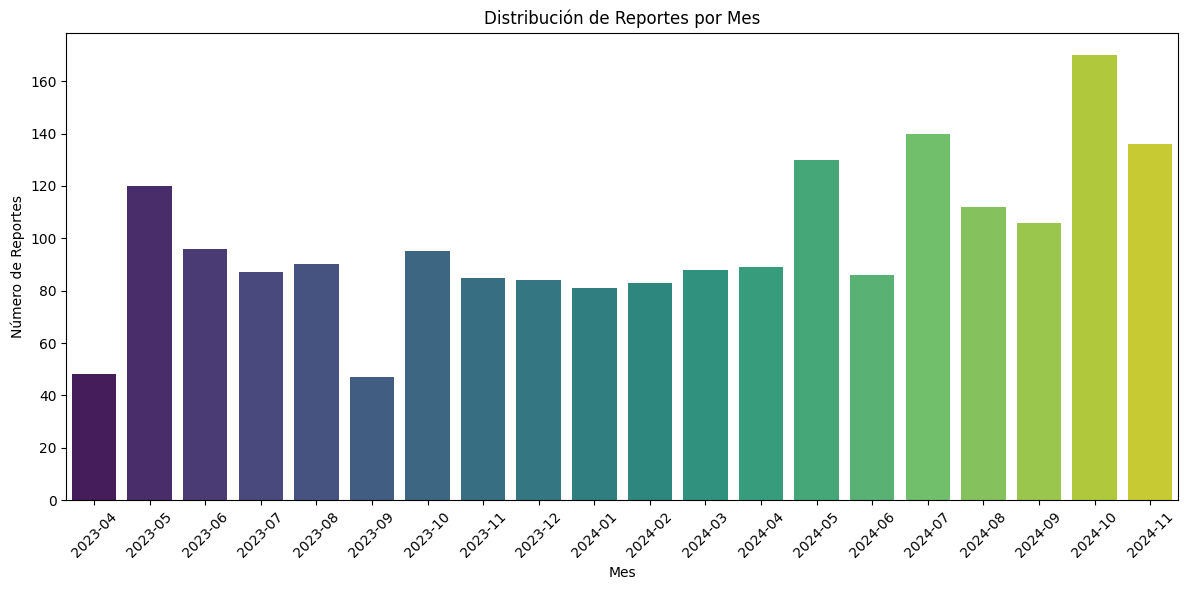

In [12]:
# Visualización por fechas 
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.to_period('M')


# Contar la cantidad de reportes por mes
month_counts = df['Month'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index.astype(str), y=month_counts.values, palette='viridis')
plt.title('Distribución de Reportes por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Reportes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocesamiento
* Eliminación de NaN en la columna RAIDD
* Eliminar espacios extras y saltos de linea
* Reemplazar vocales con tildes
* Eliminar puntuaciones y simbolos
* Pasar todo a minuscula

In [13]:
# Eliminar NaN en la columna RAIDD
df.dropna(subset=['RAIDD'], inplace=True)

In [14]:
# Se utiliza la funcion 'clean_text' para luego aplicar mediante lambds a cada fila
def clean_text(text):
  cleaned_text = re.sub("\s+", " ", text)
  return cleaned_text

df['RAIDD'] = df['RAIDD'].apply(lambda x: clean_text(str(x))) 

In [15]:
# Quitar las tildes y reemplazarlas por las vocales "limpias"
def remove_accents(text):
    # Descomponer los caracteres acentuados en sus componentes base
    text = unicodedata.normalize('NFD', text)
    # Filtrar todos los caracteres que no sean letras o dígitos
    text = ''.join([char for char in text if unicodedata.category(char) != 'Mn'])
    return text
    
df['RAIDD'] = df['RAIDD'].astype(str).apply(remove_accents)

In [16]:
# Eliminación de puntuación y símbolos
def clean_punct(text):
  cleaned_text = re.sub("[^-9A-Za-z ]", "", text)
  return cleaned_text
    
df['RAIDD'] = df['RAIDD'].apply(lambda x: clean_punct(str(x)))

In [17]:
# Todo a minúsculas
def lowercase_conv(text):

  text_clean = "".join([i.lower() for i in text if i not in string.punctuation])
  return text_clean

df['RAIDD'] = df['RAIDD'].apply(lowercase_conv)

In [18]:
df

,Client Name,Project Name,TECH-Mgmt,Tech Score,RAIDD,Public,Date,Month
0,Embonor,Ecommerce B2C,Tomás Alegre,Neutral,risks al no tener validaciones en las variabl...,Yes,2023-04-18,2023-04
1,Embonor,Ecommerce B2B,Andrés Mármol,Neutral,risks varios puntos de la infraestructura est...,Yes,2023-04-18,2023-04
2,Embonor,PDV,Jose Piamba,Neutral,risks existe el riesgo de retraso en la entre...,Yes,2023-04-18,2023-04
3,Embonor,EDF,Jonathan Delgado,Neutral,risks hay un riesgo de que no se pueda entreg...,Yes,2023-04-18,2023-04
4,Embonor,App,Victor del Rio,Neutral,risks hay un riesgo de que se pierda conocimi...,Yes,2023-04-18,2023-04
...,...,...,...,...,...,...,...,...
1968,SMU,Fidelidad,Jose Lacunza,Neutral,risks na assumptions na issues na decisions...,NaN,2024-11-27,2024-11
1969,SMU,Medios de Pago,Giomar Rodriguez,Neutral,risks na assumptions este sprint esta contro...,NaN,2024-11-27,2024-11
1970,SMU,Navegación,Hugo Rosado,Neutral,risks na assumptions na issues el equipo de...,NaN,2024-11-27,2024-11
1971,Socofar,Omniapp,Eugenio Caicedo,Neutral,risks na assumptions na issues existe un erro...,NaN,2024-11-27,2024-11


## Normalización
* Tokenizar texto
* Eliminar las Stopwords


In [19]:
# Tokenizar texto
df['RAIDD_tokens'] = df['RAIDD'].astype(str).apply(lambda x: x.lower().split())

In [20]:
# Eliminar Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

df['RAIDD_tokens_filtered'] = df['RAIDD_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Lista de stopwords adicionales
extra_stopwords = ['nan', 'na', 'risks', 'risk', 'assumptions', 'assumption', 'issues', 'issue', 'dependencies', 'decisions', 'decision']

def filter_stopwords(tokens, extra_stopwords=[]):
    combined_stopwords = stop_words.union(set(extra_stopwords))
    return [word for word in tokens if word not in combined_stopwords]

# Aplicar la función para filtrar stopwords a la columna 'RAIDD_tokens'
df['RAIDD_tokens_filtered'] = df['RAIDD_tokens'].apply(lambda tokens: filter_stopwords(tokens, extra_stopwords))

In [22]:
# Unir los tokens filtrados en una sola cadena
df['RAIDD_filtered'] = df['RAIDD_tokens_filtered'].apply(lambda tokens: ' '.join(tokens))

print(df[['RAIDD_tokens_filtered', 'RAIDD_filtered']].head())

                               RAIDD_tokens_filtered  \
0  [tener, validaciones, variables, ambiente, hac...   
1  [varios, puntos, infraestructura, estan, corri...   
2  [existe, riesgo, retraso, entrega, servicios, ...   
3  [riesgo, pueda, entregar, lista, foco, embonor...   
4  [riesgo, pierda, conocimiento, app, full, stac...   

                                      RAIDD_filtered  
0  tener validaciones variables ambiente hacen mi...  
1  varios puntos infraestructura estan corriendo ...  
2  existe riesgo retraso entrega servicios funcio...  
3  riesgo pueda entregar lista foco embonor tiemp...  
4  riesgo pierda conocimiento app full stack deve...  


In [23]:
# Contar filas 
num_filas = df.shape[0]
print(f"El DataFrame tiene {num_filas} filas.")

El DataFrame tiene 1791 filas.


## Exploración de datos curados
* Identificar consistencia de datos
    * Verificar datos en RAIDD_filtered, dropear NaN
* Eliminar columnas sin uso (Public, RAIDD_tokens, RAIDD_tokens_filtered)
* Identificar valor faltante en Project Name y completar
* Proyectos por cliente y sus reportes
* Clientes con mayor cantidad de proyectos
* Clientes con mayor tiempo en Apply Digital
* Cuenta de Tech Score por cliente

In [24]:
# Identificar consistencia de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1791 entries, 0 to 1972
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Client Name            1791 non-null   object        
 1   Project Name           1790 non-null   object        
 2   TECH-Mgmt              1791 non-null   object        
 3   Tech Score             1764 non-null   object        
 4   RAIDD                  1791 non-null   object        
 5   Public                 761 non-null    object        
 6   Date                   1791 non-null   datetime64[ns]
 7   Month                  1791 non-null   period[M]     
 8   RAIDD_tokens           1791 non-null   object        
 9   RAIDD_tokens_filtered  1791 non-null   object        
 10  RAIDD_filtered         1791 non-null   object        
dtypes: datetime64[ns](1), object(9), period[M](1)
memory usage: 167.9+ KB


In [25]:
# Verificar datos nulos en RAIDD_filtered

In [26]:
# Eliminar las columnas 'Public', 'RAIDD_tokens' y 'RAIDD_tokens_filtered'
df = df.drop(columns=['Public', 'RAIDD_tokens', 'RAIDD_tokens_filtered'])
print(df.head())

  Client Name   Project Name         TECH-Mgmt Tech Score  \
0     Embonor  Ecommerce B2C      Tomás Alegre    Neutral   
1     Embonor  Ecommerce B2B     Andrés Mármol    Neutral   
2     Embonor            PDV       Jose Piamba    Neutral   
3     Embonor            EDF  Jonathan Delgado    Neutral   
4     Embonor            App    Victor del Rio    Neutral   

                                               RAIDD       Date    Month  \
0  risks  al no tener validaciones en las variabl... 2023-04-18  2023-04   
1  risks  varios puntos de la infraestructura est... 2023-04-18  2023-04   
2  risks  existe el riesgo de retraso en la entre... 2023-04-18  2023-04   
3  risks  hay un riesgo de que no se pueda entreg... 2023-04-18  2023-04   
4  risks  hay un riesgo de que se pierda conocimi... 2023-04-18  2023-04   

                                      RAIDD_filtered  
0  tener validaciones variables ambiente hacen mi...  
1  varios puntos infraestructura estan corriendo ...  
2  existe r

In [27]:
# Identificar valor faltante en Project Name y completar
filas_nulas = df[df['Project Name'].isnull()]
# Mostrar las filas que tienen valores nulos en 'Project Name'
print(filas_nulas)

     Client Name Project Name      TECH-Mgmt Tech Score  \
523  Bancolombia          NaN  Jaime Vasquez    Neutral   

                                                 RAIDD       Date    Month  \
523  risks na assumptions na issues na decisions  s... 2023-10-17  2023-10   

                                       RAIDD_filtered  
523  trabajando identificacion agrupacion componentes  


In [28]:
df = df.dropna(subset=['Project Name'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 0 to 1972
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Client Name     1790 non-null   object        
 1   Project Name    1790 non-null   object        
 2   TECH-Mgmt       1790 non-null   object        
 3   Tech Score      1763 non-null   object        
 4   RAIDD           1790 non-null   object        
 5   Date            1790 non-null   datetime64[ns]
 6   Month           1790 non-null   period[M]     
 7   RAIDD_filtered  1790 non-null   object        
dtypes: datetime64[ns](1), object(6), period[M](1)
memory usage: 125.9+ KB


In [30]:
# Agrupar por 'Client Name' y 'Project Name', y contar los reportes RAIDD
reportes_por_cliente_proyecto = df.groupby(['Client Name', 'Project Name']).size().reset_index(name='RAIDD Count')

# Ordenar el resultado de manera descendente por 'RAIDD Count'
reportes_por_cliente_proyecto = reportes_por_cliente_proyecto.sort_values(by='RAIDD Count', ascending=False)
print(reportes_por_cliente_proyecto)

                Client Name             Project Name  RAIDD Count
16                  Embonor                      App           65
14                   Curran                      MVP           62
73                      SMU               Navegación           56
5                 Atlassian  Knowledge Base Platform           55
71                      SMU           Medios de Pago           55
..                      ...                      ...          ...
38  Managed Services (CAAS)            Noble Panacea            7
39  Managed Services (CAAS)              White Stuff            7
46          Managed service                  Tishman            3
53                 Millicom                 Garantía            3
77                 Tishmann                       ZO            3

[79 rows x 3 columns]


In [31]:
# Clientes con mayor cantidad de proyectos
# Agrupar por 'Client Name' y contar el número de proyectos únicos
proyectos_por_cliente = df.groupby('Client Name')['Project Name'].nunique().reset_index(name='Project Count')

# Ordenar los resultados de manera descendente por 'Project Count'
proyectos_por_cliente = proyectos_por_cliente.sort_values(by='Project Count', ascending=False)

# Seleccionar los 10 clientes con mayor cantidad de proyectos
top_10_clientes = proyectos_por_cliente.head(10)

# Mostrar el resultado
print(top_10_clientes)

                Client Name  Project Count
9                   Embonor              9
13  Managed Services (CAAS)              8
21                      SMU              7
18                  Moderna              7
16                 Millicom              6
10                      GAC              5
14  Managed Services (PAAS)              5
15          Managed service              4
7            Caja Los Andes              3
20                      NFL              3


In [32]:
# Clientes con mayor tiempo en Apply Digital
# Convertir 'Date' a formato de fecha si no lo está ya
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Calcular el rango de fechas para cada cliente
tiempo_por_cliente = df.groupby('Client Name')['Date'].agg(['min', 'max'])

# Calcular la duración en días
tiempo_por_cliente['Duration'] = (tiempo_por_cliente['max'] - tiempo_por_cliente['min']).dt.days

# Ordenar los resultados de manera descendente por 'Duration'
tiempo_por_cliente = tiempo_por_cliente.sort_values(by='Duration', ascending=False)

# Seleccionar los clientes con mayor tiempo
clientes_mayor_tiempo = tiempo_por_cliente.reset_index()

# Mostrar el resultado
print(clientes_mayor_tiempo)

                Client Name        min        max  Duration
0                   Embonor 2023-04-18 2024-11-27       589
1                       SMU 2023-04-18 2024-11-27       589
2                    Curran 2023-04-18 2024-07-17       456
3                 Atlassian 2023-04-18 2024-06-26       435
4             Apply Digital 2023-10-24 2024-11-27       400
5               Bancolombia 2023-10-24 2024-11-27       400
6                       NBA 2023-10-24 2024-11-27       400
7           Managed service 2023-10-24 2024-09-25       337
8            Caja Los Andes 2023-10-17 2024-08-28       316
9                  Americar 2024-01-23 2024-11-27       309
10                      NFL 2024-01-23 2024-11-27       309
11                      GAC 2023-04-18 2024-01-09       266
12                   Mirion 2024-05-01 2024-11-20       203
13                 Tishmann 2023-04-18 2023-11-07       203
14                  Socofar 2024-05-15 2024-11-27       196
15                     Wynn 2024-05-22 2

In [33]:
# Cuenta de Tech Score por cliente
tech_score_counts = df.groupby(['Client Name', 'Tech Score']).size().unstack(fill_value=0)
print(tech_score_counts)

Tech Score               High  Low  Neutral
Client Name                                
Alltech                     0    0        6
Americar                    0    0       42
Apply Digital               0    0       53
Atlassian                   0    0       55
Bancolombia                 2    0       41
Black and Veatch            0    0       16
CaaS                        0    0       36
Caja Los Andes              0    0       73
Curran                      0    0       61
Embonor                     0    0      346
GAC                         0    0      119
Harvard                     0   14        7
Liverpool                   0    0       28
Managed Services (CAAS)     0    0       50
Managed Services (PAAS)     0    0       39
Managed service             0    0       98
Millicom                    0    6       81
Mirion                      0    0       17
Moderna                     0    0      114
NBA                         0    0       46
NFL                         0   

## Vectorización
* Creación de embeddings
* Creción listados de embeddings y string
* Creación archivos TSV y CSV

Representación numérica de palabras o frases en un espacio vectorial continuo. Esta representación permite capturar el significado semántico de las palabras a través de vectores que pueden ser utilizados para medir distancias y similitudes entre palabras.

In [34]:
model = SentenceTransformer('all-mpnet-base-v2') 
df['embeddings'] = df['RAIDD_filtered'].apply(lambda x: model.encode(x))

In [35]:
df['embeddings'][0]

array([-1.97313298e-02, -3.36189494e-02, -1.30389361e-02, -9.63319615e-02,
        2.59911846e-02, -4.88934340e-03,  4.25353982e-02,  1.34459622e-02,
        2.90048961e-02,  1.84996314e-02,  2.75308955e-02,  1.09763585e-01,
        5.33594787e-02,  4.96182553e-02, -3.63638513e-02,  2.77087446e-02,
        2.10168064e-02,  3.91507009e-03, -4.64538410e-02,  2.25278269e-03,
       -1.93054676e-02,  3.95776741e-02,  2.26539047e-03, -2.25460809e-02,
        4.23398428e-02, -3.84769887e-02,  4.87179123e-02, -2.03608312e-02,
       -3.60937061e-04,  1.27044637e-02,  5.42707890e-02, -1.17893182e-02,
        6.99204579e-03,  1.18709607e-02,  2.27566898e-06, -4.33074199e-02,
        3.55904214e-02,  1.32563720e-02, -3.48776616e-02, -4.20064069e-02,
       -2.07394250e-02, -3.91483791e-02,  5.44291036e-03,  2.73655653e-02,
       -6.29651733e-03, -1.41798453e-02, -3.67138050e-02,  4.25976962e-02,
        8.18829685e-02,  1.23223346e-02,  3.08348169e-03,  7.37025589e-02,
       -1.28241386e-02, -

In [36]:
embedding_list = df['embeddings'].tolist()  
string_list = df['RAIDD_filtered'].tolist()

#ambos listados deben tener la misma cantidad de observaciones
print(len(embedding_list))
print(len(string_list))

1790
1790


In [48]:
print(string_list[5])

ninguno parte desarrollo retraso lado contenido deberia ser afecte directamente varios equipos dentro atlassian quieren subir contenido sitio probablemente ajustar varias veces content model soportar estructura nuevo contenido futuro equipo parte atlassian empezo tomar tareas sprint relacionado seo ahora trabajaran cambios implentacion analytics depende equipo interno analytics depende equipo interno algolia empezar trabajar search sitio incluir contenido success central propiedades atlassian


In [37]:
# TSV and CSV files
# embeddings a archivo TSV 
embeddings_df = pd.DataFrame(embedding_list)
embeddings_df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

# etiquetas a archivo TSV
labels_df = pd.DataFrame(string_list)
labels_df.to_csv('metadata.tsv', sep='\t', index=False, header=False)

# Guardar csv limpio
df.to_csv("raidd_clean.csv", index=True)

# T-SNE
* DBSCAN + t-SNE


In [51]:
df = pd.read_csv('raidd_clean.csv')

In [52]:
from sklearn.manifold import TSNE

C:\Users\simon\AppData\Local\Temp\ipykernel_19140\147316483.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
C:\Users\simon\Documents\Tesina\testLlama\Lib\site-packages\mplcursors\_pick_info.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


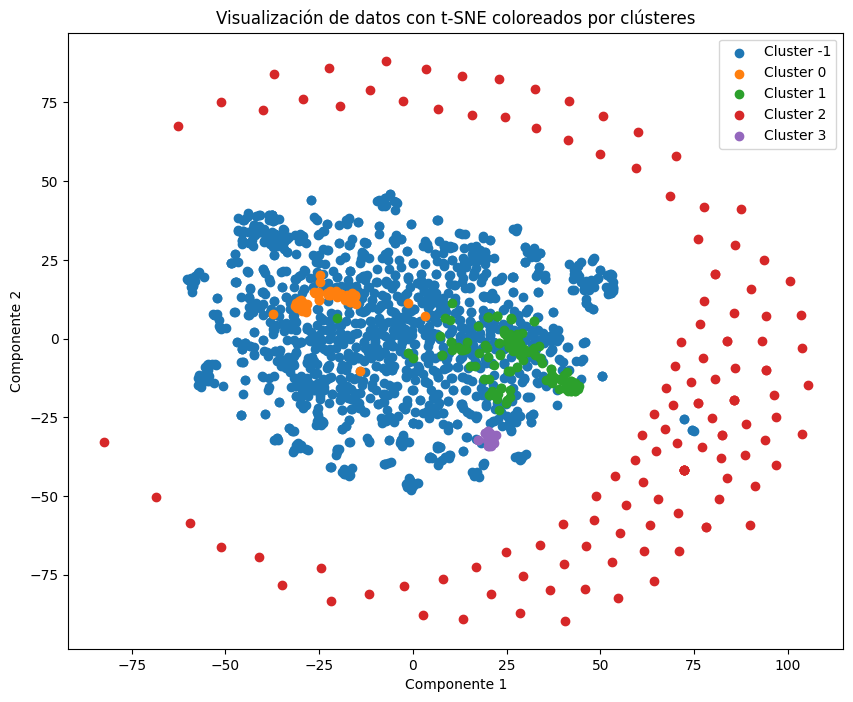

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

X = np.array(embedding_list)

#DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=20).fit(X)
labels = dbscan.labels_

# t-SNE
X_embedded = TSNE(n_components=2, learning_rate = 'auto', init='random', perplexity=30).fit_transform(X)

# Colorear 
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    indices = labels == label
    plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=f'Cluster {label}', cmap=colors)

plt.title('Visualización de datos con t-SNE coloreados por clústeres')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()

In [106]:
# Asumiendo que 'embedding_list' y 'string_list' están definidos
X = np.array(embedding_list)

# Aplicar DBSCAN para identificar clústeres
dbscan = DBSCAN(eps=0.7, min_samples=20).fit(X)
labels = dbscan.labels_

# Crear un diccionario para almacenar los resultados
clusters_dict = {}

# Iterar sobre los clústeres únicos
unique_labels = np.unique(labels)
for label in unique_labels:
    # Crear un diccionario para cada clúster
    cluster_dict = {}
    # Encontrar los índices de los puntos en este clúster
    indices = np.where(labels == label)[0]
    # Asociar cada índice con su string correspondiente
    for index in indices:
        cluster_dict[index] = string_list[index]
    # Almacenar el diccionario del clúster en el diccionario principal
    clusters_dict[label] = cluster_dict

# Mostrar el resultado
for label, cluster in clusters_dict.items():
    print(f'Cluster {label}:')
    for index, string in cluster.items():
        print(f'  Posición: {index}, String: {string}')
    print('---')

Cluster -1:
  Posición: 0, String: tener validaciones variables ambiente hacen migraciones helm repositorio helm migrado github actions ocasiones servicios quedan abajo tener conocimiento falta variables existe falta tiempo migracion servicios github actions conversaciones priorizar servicios ver cuales mas criticos migrar proyectos cuentan validador variables ambiente cuales estan empezando implementar manera progresiva fallas seguridad archivos docker estan solvendanto actualizando versiones librerias node trabajando upgrade librerias transformar ciertas funciones lambda servicios backend solver ciertos problemas estandar codigo problemas seguridad trabajando sistema versionamiento automatico semancticrelease servicios nuevos manera tal estandar versiones automatico
  Posición: 2, String: existe riesgo retraso entrega servicios funcionalidades pdv embol cambios fuentes datos ocasionado fallos procesos etl implementacion funcionalidades embol generado dependencias hacia terceros sopor

Cluster -1:

El Cluster -1 parece agrupar situaciones de riesgo y desafíos en la gestión de proyectos. Los elementos comunes incluyen problemas de comunicación y coordinación, tanto internos como con clientes. Hay menciones recurrentes a riesgos de seguridad, como el uso de versiones antiguas de software y problemas de seguridad en los servicios. También se observa una preocupación por la pérdida de conocimiento debido a la rotación del personal, lo que afecta la capacidad de respuesta ante incidentes. Otro patrón notable es la dependencia de terceros y la necesidad de aprobación para completar tareas, lo que genera retrasos. La falta de claridad en las especificaciones y la necesidad de redefinir prioridades también son temas recurrentes. Estos factores indican una necesidad de mejorar la planificación, la comunicación, y la gestión de recursos para mitigar riesgos y optimizar el flujo de trabajo.
Cluster 0:

En el Cluster 0, los temas principales giran en torno a la infraestructura y la deuda técnica. Se menciona que varios sistemas están operando con versiones de software obsoletas, lo que podría llevar a problemas de compatibilidad y seguridad. La dependencia de sistemas compartidos y la necesidad de realizar pruebas transversales complican el desarrollo y pueden causar retrasos. Hay una fuerte interdependencia entre equipos, lo que requiere una coordinación cuidadosa para evitar conflictos y asegurar que los objetivos estratégicos se cumplan. La gestión de la deuda técnica parece ser una prioridad, ya que su acumulación podría afectar negativamente la capacidad de respuesta y la flexibilidad del proyecto. Este clúster resalta la importancia de actualizar y mantener la infraestructura para evitar riesgos futuros y mejorar la eficiencia operativa.
Cluster 2:

Datos vacíos.
Cluster 3:

El Cluster 3 está centrado en la gestión de tickets y el flujo de trabajo en proyectos de desarrollo. Se observan problemas con la priorización y la finalización de tickets, lo que lleva a retrasos en las entregas y la necesidad de ajustes en los cronogramas. La falta de claridad en las descripciones de los tickets y la necesidad de revisar y refinar continuamente las tareas son desafíos comunes. También se menciona la gestión del tiempo y los recursos, con un enfoque en optimizar la disponibilidad de horas y mejorar la coordinación entre equipos. La necesidad de abordar tareas pendientes y gestionar el backlog de manera efectiva es crucial para mantener el ritmo de desarrollo. Este clúster destaca la importancia de una gestión de tickets eficiente y una comunicación clara para evitar cuellos de botella y asegurar el cumplimiento de los plazos.

    Cluster -1: Gestión de Riesgos y Comunicación Este clúster destaca la importancia de gestionar riesgos y mejorar la comunicación en proyectos tecnológicos. Los problemas de seguridad, la falta de validaciones y la pérdida de conocimiento debido a la rotación del personal son temas recurrentes. La dependencia de terceros y la necesidad de aprobación para completar tareas generan retrasos. La planificación deficiente y la falta de claridad en las especificaciones afectan la eficiencia. Se recomienda mejorar los procesos de comunicación, establecer protocolos de seguridad robustos y asegurar la transferencia de conocimiento para mitigar riesgos y optimizar el flujo de trabajo.

    Cluster 0: Infraestructura y Deuda Técnica En este clúster, la infraestructura obsoleta y la deuda técnica son preocupaciones clave. Los sistemas operan con software desactualizado, lo que puede llevar a problemas de compatibilidad y seguridad. La interdependencia de sistemas y la necesidad de pruebas transversales complican el desarrollo. La gestión de la deuda técnica es crucial para evitar impactos negativos en la flexibilidad y capacidad de respuesta. Se sugiere priorizar la actualización de la infraestructura y establecer un plan para abordar la deuda técnica, asegurando que los sistemas sean seguros y eficientes.

    Cluster 2: Datos Vacíos Este clúster contiene datos vacíos, lo que indica una falta de información útil. Es importante revisar la fuente de estos datos para asegurar su integridad y completitud.

    Cluster 3: Gestión de Tickets y Flujo de Trabajo Este clúster resalta la importancia de una gestión eficiente de tickets y el flujo de trabajo en proyectos de desarrollo. Los problemas con la priorización y finalización de tickets llevan a retrasos y ajustes en los cronogramas. La claridad en las descripciones de tickets y la coordinación entre equipos son esenciales para evitar cuellos de botella. Se recomienda optimizar la gestión de tickets y mejorar la comunicación para asegurar el cumplimiento de plazos y mantener el ritmo de desarrollo.

    Optimización de Hiperparámetros: Los métodos de Grid Search y Random Search son efectivos para ajustar los hiperparámetros de DBSCAN y UMAP, maximizando la calidad de los clústeres. Estos enfoques sistemáticos ayudan a explorar combinaciones de parámetros, asegurando una representación precisa de la estructura de los datos. La evaluación con el coeficiente de silueta es crucial para determinar el mejor ajuste. Este análisis permite identificar configuraciones óptimas, mejorando la agrupación y facilitando la interpretación de los datos.

    Propuestas de Gestión de Proyectos: Basado en los patrones observados, se recomienda implementar una gestión de proyectos más estructurada. Esto incluye establecer procesos claros para la comunicación y la gestión de riesgos, priorizar la actualización de la infraestructura, y optimizar la gestión de tickets. Además, fomentar la transferencia de conocimiento y la capacitación del personal ayudará a mitigar la pérdida de conocimiento. Estas mejoras pueden aumentar la eficiencia, reducir retrasos y asegurar el éxito de los proyectos tecnológicos.


# DBSCAN + UMAP

C:\Users\simon\AppData\Local\Temp\ipykernel_19140\1462266508.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
C:\Users\simon\Documents\Tesina\testLlama\Lib\site-packages\mplcursors\_pick_info.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


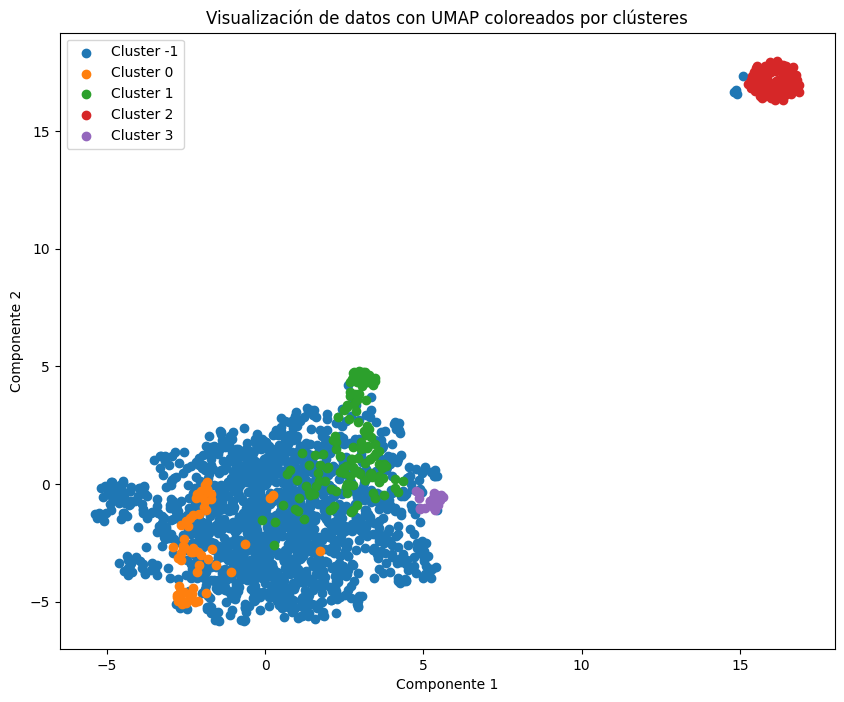

In [140]:
X = np.array(embedding_list)

#DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=20).fit(X)
labels = dbscan.labels_

reducer = umap.UMAP(n_neighbors=60, min_dist=0.8, n_components=2, metric='euclidean')
umap_embeddings = reducer.fit_transform(embedding_list)

# Colorear 
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    indices = labels == label
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=f'Cluster {label}', cmap=colors)

plt.title('Visualización de datos con UMAP coloreados por clústeres')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()


## Random Search

In [111]:
import random

# Definir el espacio de búsqueda para los hiperparámetros
param_dist = {
    'eps': [0.5, 0.6, 0.7],
    'min_samples': [10, 20, 25]
}

n_iter = 10  # Número de combinaciones a probar
best_score = -1
best_params = None

# Realizar Random Search
for _ in range(n_iter):
    params = {key: random.choice(values) for key, values in param_dist.items()}
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples']).fit(X)
    labels = dbscan.labels_
    
    # Filtrar los puntos que no son considerados ruido
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        score = silhouette_score(X[mask], labels[mask])
        print(f"Params: {params}, Silhouette Score: {score}")
        
        if score > best_score:
            best_score = score
            best_params = params

print(f"Mejores parámetros (Random Search): {best_params}, Mejor Coeficiente de Silueta: {best_score}")

Params: {'eps': 0.7, 'min_samples': 25}, Silhouette Score: 0.583855390548706
Params: {'eps': 0.6, 'min_samples': 20}, Silhouette Score: 0.8968963027000427
Params: {'eps': 0.6, 'min_samples': 25}, Silhouette Score: 0.9134783744812012
Params: {'eps': 0.5, 'min_samples': 20}, Silhouette Score: 1.0
Params: {'eps': 0.6, 'min_samples': 20}, Silhouette Score: 0.8968963027000427
Params: {'eps': 0.6, 'min_samples': 10}, Silhouette Score: 0.771323561668396
Params: {'eps': 0.6, 'min_samples': 20}, Silhouette Score: 0.8968963027000427
Params: {'eps': 0.6, 'min_samples': 20}, Silhouette Score: 0.8968963027000427
Params: {'eps': 0.7, 'min_samples': 25}, Silhouette Score: 0.583855390548706
Params: {'eps': 0.7, 'min_samples': 20}, Silhouette Score: 0.508990466594696
Mejores parámetros (Random Search): {'eps': 0.5, 'min_samples': 20}, Mejor Coeficiente de Silueta: 1.0


## Grid Search

In [112]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import numpy as np

# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'eps': [0.5, 0.6, 0.7],
    'min_samples': [10, 20, 25]
}

best_score = -1
best_params = None

# Realizar Grid Search
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples']).fit(X)
    labels = dbscan.labels_
    
    # Filtrar los puntos que no son considerados ruido
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        score = silhouette_score(X[mask], labels[mask])
        print(f"Params: {params}, Silhouette Score: {score}")
        
        if score > best_score:
            best_score = score
            best_params = params

print(f"Mejores parámetros (Grid Search): {best_params}, Mejor Coeficiente de Silueta: {best_score}")

Params: {'eps': 0.5, 'min_samples': 10}, Silhouette Score: 0.8687335848808289
Params: {'eps': 0.5, 'min_samples': 20}, Silhouette Score: 1.0
Params: {'eps': 0.6, 'min_samples': 10}, Silhouette Score: 0.771323561668396
Params: {'eps': 0.6, 'min_samples': 20}, Silhouette Score: 0.8968963027000427
Params: {'eps': 0.6, 'min_samples': 25}, Silhouette Score: 0.9134783744812012
Params: {'eps': 0.7, 'min_samples': 10}, Silhouette Score: 0.4053083062171936
Params: {'eps': 0.7, 'min_samples': 20}, Silhouette Score: 0.508990466594696
Params: {'eps': 0.7, 'min_samples': 25}, Silhouette Score: 0.583855390548706
Mejores parámetros (Grid Search): {'eps': 0.5, 'min_samples': 20}, Mejor Coeficiente de Silueta: 1.0


In [138]:
import random

# Definir el espacio de búsqueda para los hiperparámetros de UMAP
param_dist_umap = {
    'n_neighbors': [30, 60, 90],
    'min_dist': [0.3, 0.5, 0.7]
}

n_iter_umap = 10  # Número de combinaciones a probar
best_score_umap = -1
best_params_umap = None

# Realizar Random Search para UMAP
for _ in range(n_iter_umap):
    params = {key: random.choice(values) for key, values in param_dist_umap.items()}
    reducer = umap.UMAP(n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], n_components=2, metric='cosine')
    umap_embeddings = reducer.fit_transform(X)
    
    # Aplicar DBSCAN a los datos embebidos
    dbscan = DBSCAN(eps=0.7, min_samples=25).fit(umap_embeddings)
    labels = dbscan.labels_
    
    # Filtrar los puntos que no son considerados ruido
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        score = silhouette_score(umap_embeddings[mask], labels[mask])
        print(f"Params: {params}, Silhouette Score: {score}")
        
        if score > best_score_umap:
            best_score_umap = score
            best_params_umap = params

print(f"Mejores parámetros (Random Search UMAP): {best_params_umap}, Mejor Coeficiente de Silueta: {best_score_umap}")

Params: {'n_neighbors': 90, 'min_dist': 0.5}, Silhouette Score: 0.2881915867328644
Params: {'n_neighbors': 60, 'min_dist': 0.5}, Silhouette Score: 0.42657166719436646
Params: {'n_neighbors': 60, 'min_dist': 0.7}, Silhouette Score: 0.2725221812725067
Params: {'n_neighbors': 30, 'min_dist': 0.5}, Silhouette Score: 0.22861790657043457
Params: {'n_neighbors': 30, 'min_dist': 0.3}, Silhouette Score: 0.2377488613128662
Params: {'n_neighbors': 60, 'min_dist': 0.5}, Silhouette Score: 0.20372679829597473
Params: {'n_neighbors': 30, 'min_dist': 0.5}, Silhouette Score: 0.18699440360069275
Params: {'n_neighbors': 30, 'min_dist': 0.7}, Silhouette Score: 0.20983658730983734
Params: {'n_neighbors': 30, 'min_dist': 0.3}, Silhouette Score: 0.2172027826309204
Params: {'n_neighbors': 30, 'min_dist': 0.5}, Silhouette Score: 0.15320315957069397
Mejores parámetros (Random Search UMAP): {'n_neighbors': 60, 'min_dist': 0.5}, Mejor Coeficiente de Silueta: 0.42657166719436646


## Reducción de Dimensionalidad con UMAP
UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad que se utiliza para visualizar y analizar datos de alta dimensionalidad de manera efectiva

In [38]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.3, n_components=2, metric='euclidean')
umap_embeddings = reducer.fit_transform(embedding_list)

## Clustering
* Método de Elbow
* Aplicación de K-Means
    * Coeficientes
* Aplicación de DBSCAN
    * Coeficientes

### K-Means

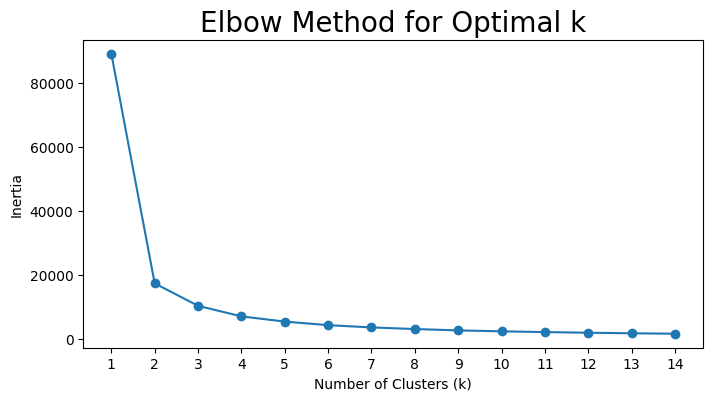

In [141]:
inertia = []
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

k_values = range(1, 15)  
for k in k_values:
    kmeans = KMeans(n_clusters=k,  **kmeans_kwargs).fit(umap_embeddings)
    inertia.append(kmeans.inertia_)

# Visualizar el metodo de codo
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=20)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.xticks(k_values)
plt.show()

In [142]:
num_clusters = 5
kmeans = KMeans(init="random", n_clusters=num_clusters, n_init=10, max_iter=300, random_state=42)
clusters = kmeans.fit_predict(umap_embeddings)
df['cluster'] = clusters

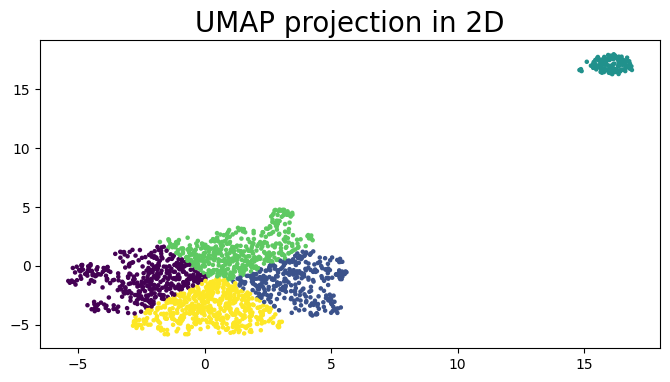

In [143]:
plt.figure(figsize=(8, 4))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clusters, s=5)
plt.title('UMAP projection in 2D', fontsize=20)
plt.show()

In [144]:
print(silhouette_score(umap_embeddings, kmeans.labels_))
print(davies_bouldin_score(umap_embeddings, kmeans.labels_))

0.38833207
0.7769415741499156


### DBSCAN

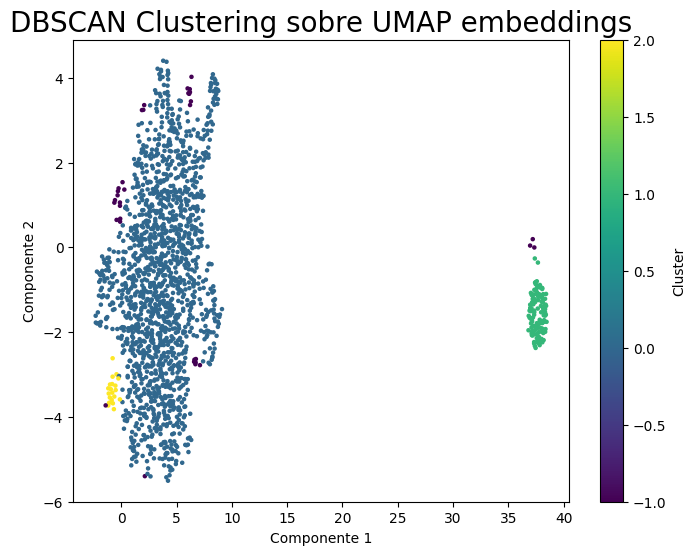

Coeficiente de Silueta: 0.2732795178890228


In [146]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Supongamos que umap_embeddings ya ha sido calculado previamente
umap_embeddings = reducer.fit_transform(embedding_list)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=20, metric='euclidean', algorithm='auto', leaf_size=30, n_jobs=None)
clusters = dbscan.fit_predict(umap_embeddings)

# Agregar las etiquetas de los clusters al DataFrame original
df['dbscan_cluster'] = clusters

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clusters, s=5, cmap='viridis')
plt.title('DBSCAN Clustering sobre UMAP embeddings', fontsize=20)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

# Filtrar los puntos que no son considerados ruido por DBSCAN
mask = df['dbscan_cluster'] != -1
filtered_labels = df.loc[mask, 'dbscan_cluster']
filtered_embeddings = umap_embeddings[mask]

# Verificar que hay al menos 2 clústeres para calcular el coeficiente de silueta
if len(set(filtered_labels)) > 1:
    silhouette = silhouette_score(filtered_embeddings, filtered_labels)
    print(f'Coeficiente de Silueta: {silhouette}')
else:
    print("No es posible calcular el coeficiente de silueta con un solo clúster o solo ruido.")

## Análisis